# **Feed Forward Neural Network**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import time
import os

# For preprocessing
import tensorflow as tf

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

# Operational
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import random

In [3]:
pkl_path = '/content/drive/My Drive/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'
# pkl_path = 'C:/Users/thato/Documents/Final-Year-Project/Dataset/Final-Version-of-Bird-Classification-Project/feature-extraction/Annotated/Regular/NotAveragePooled/split_features_3s_all_2D.pkl'

# Load the pickle file
with open(pkl_path, 'rb') as file:
    data = pickle.load(file)
del file

In [20]:
path = '/content/drive/My Drive/Final-Year-Project/Final-Version-of-Bird-Classification-Project/Final-Version-of-Bird-Classification-Project/a. Imbalanced-Data/3. Training/Figures/FFNN/'

In [5]:
train_data = data['train'].copy()
val_data = data['val'].copy()
del data

train_labels = train_data['label'].copy()
temp = train_data.copy()
del temp['label']
tr_features = temp

val_labels = val_data['label'].copy()
temp = val_data.copy()
del temp['label']
v_features = temp

## **Shuffling Data**

In [6]:
def shuffle_data(input_label, input_features):
  input_len = len(input_label)
  np.random.seed(1826)
  input_indices = np.random.permutation(input_len)
  input_features = {key: np.array([input_features[key][i] for i in input_indices]) for key in input_features} # dictionary comprehension
  input_label = np.array([input_label[i] for i in input_indices])

  return input_label, input_features

In [7]:
train_y, train_features = shuffle_data(train_labels, tr_features)

In [8]:
val_y, val_features = shuffle_data(val_labels, v_features)

## **FFNN Model**

In [9]:
def build_model(audio_features,
                hidden_layers,
                learning_rate,
                dropout_rate,
                regularizer_val,
                output_units=20
                ):

  tf.keras.backend.clear_session()

  # set input layer
  input = tf.keras.Input(shape=(audio_features.shape[1],), name='Input')

  # set hidden layers
  hidden_output = input

  for i, hidden_dim in enumerate(hidden_layers):
    hidden_output = tf.keras.layers.Dense(units=hidden_dim,
                                          activation='relu',
                                          kernel_regularizer=tf.keras.regularizers.l2(regularizer_val),
                                          name=f'hidden{i}')(hidden_output)
    hidden_output = tf.keras.layers.Dropout(rate=dropout_rate, name=f'dropout{i}')(hidden_output)

  # set output layer
  output = tf.keras.layers.Dense(units=output_units,
                                 activation='softmax',
                                 name='Output')(hidden_output)
  # create model
  model = tf.keras.models.Model(inputs=input, outputs=[output])

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [10]:
def visualize(model_history, name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Visualize the loss
    axes[0].plot(model_history.history['loss'], color='red', label='Training Loss')
    axes[0].plot(model_history.history['val_loss'], color='blue', label='Validation Loss')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss Progression', fontsize=14)
    axes[0].grid(True)
    axes[0].legend()

    # Visualize the accuracy
    axes[1].plot(model_history.history['accuracy'], color='green', label='Training Accuracy')
    axes[1].plot(model_history.history['val_accuracy'], color='orange', label='Validation Accuracy')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Accuracy Progression', fontsize=14)
    axes[1].grid(True)
    axes[1].legend()

    plt.savefig(f'{path+name}_3s_model_training_history_2D_annotated_testingtuning.pdf')

    # Fine-tune layout and display the plots
    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(val_y, val_yhat, val_yhat_result, num_classes=20):

    print('Validation classification Report \n')
    print(classification_report(val_y, val_yhat_result))

    # Calculate AUC for multiclass classification using 'ovr' and 'weighted' average
    auc_score = roc_auc_score(val_y, val_yhat, multi_class='ovr', average='weighted')
    print(f'AUC Score: {auc_score}')

    # Calculate F1-score with 'weighted' average for imbalanced dataset
    f1 = f1_score(val_y, val_yhat_result, average='weighted')
    print(f'F1 Score (Weighted): {f1}')

    val_score = {'f1': f1, 'auc': auc_score}

    return val_score

In [12]:
def tile_and_crop(feature, target_size):
    tiled = np.tile(feature, (1, target_size // feature.shape[1] + 1, 1))
    return tiled[:, :target_size, :]

In [13]:
def build_and_train_models(model_configs, train_features, train_y, val_features, val_y, train_results, val_results, val_scores, epochs=100, batch_size=32):
    """
    Build, train, and evaluate multiple models based on configurations provided in model_configs.

    Parameters:
    - model_configs: Dictionary where each key is a model name and the value is a config dictionary for that model.
    - train_features: Training features (e.g., mel spectrograms + MFCC).
    - train_y: Training labels.
    - val_features: Validation features (e.g., mel spectrograms + MFCC).
    - val_y: Validation labels.
    - train_results: Dictionary to store training results (e.g., accuracy).
    - val_results: Dictionary to store validation results (e.g., accuracy).
    - val_scores: Dictionary to store validation metrics like precision, recall, etc.
    - epochs: Number of epochs to train each model.
    - batch_size: Batch size for training.

    Returns:
    - None (modifies train_results, val_results, and val_scores in place).
    """

    for model_name, config in model_configs.items():
        print(f"Building and training {model_name}...")

        # Unpack the configuration for each model
        learning_rate = config.get('learning_rate')
        dropout_rate = config.get('dropout_rate')
        hidden_layers = config.get('hidden_layers')
        regularizer_val = config.get('regularizer_val')

        # Build the model
        model = build_model(
            audio_features=train_features,
            hidden_layers=hidden_layers,
            learning_rate=learning_rate,
            dropout_rate=dropout_rate,
            regularizer_val=regularizer_val
        )

        # Train the model
        history = model.fit(
            x=train_features,
            y=train_y,
            epochs=epochs,
            validation_data=(val_features, val_y),
            batch_size=batch_size,
            verbose=1
        )

        # Visualize training history
        visualize(history, model_name)

        # Evaluate model on training data
        train_yhat = model.predict(train_features)
        train_yhat_result = np.argmax(train_yhat, axis=-1)
        train_results[model_name] = model.evaluate(train_features, train_y)[-1]

        # Evaluate model on validation data
        val_yhat = model.predict(val_features)
        val_yhat_result = np.argmax(val_yhat, axis=-1)
        val_results[model_name] = model.evaluate(val_features, val_y)[-1]

        # Store validation scores (like accuracy, precision, recall, etc.)
        val_scores[model_name] = evaluate_model(val_y=val_y, val_yhat=val_yhat, val_yhat_result=val_yhat_result)

        print(f"Completed training and evaluation for {model_name}.\n")

In [22]:
model_configs = {
    'model_1': {
        'hidden_layers': [128, 64, 32],
        'learning_rate': 0.0001,
        'dropout_rate': 0.3,
        'regularizer_val': 0.0015
    },
    'model_2': {
        'hidden_layers': [256, 128, 64],
        'learning_rate': 0.0002,
        'dropout_rate': 0.4,
        'regularizer_val': 0.002
    },
    'model_3': {
        'hidden_layers': [128, 64, 64],
        'learning_rate': 0.00005,
        'dropout_rate': 0.5,
        'regularizer_val': 0.0005
    },
    'model_4': {
        'hidden_layers': [128, 128, 64],
        'learning_rate': 0.0003,
        'dropout_rate': 0.3,
        'regularizer_val': 0.001
    },
    'model_5': {
        'hidden_layers': [64, 64, 32],
        'learning_rate': 0.0001,
        'dropout_rate': 0.35,
        'regularizer_val': 0.0015
    },
    'model_6': {
        'hidden_layers': [256, 128],
        'learning_rate': 0.0001,
        'dropout_rate': 0.4,
        'regularizer_val': 0.12
    }
}


In [15]:
train_results = {}
val_results = {}

val_scores = {}

### With Mel Spectrogram, MFCCs, Chroma

In [16]:
training_features_3D = np.concatenate((train_features['mfcc'], train_features['chroma'], train_features['melspectrogram']), axis=1)
training_features = training_features_3D.reshape(training_features_3D.shape[0], -1)
training_features.shape

(5278, 41440)

In [17]:
validation_features_3D = np.concatenate((val_features['mfcc'], val_features['chroma'], val_features['melspectrogram']), axis=1)
validation_features = validation_features_3D.reshape(validation_features_3D.shape[0], -1)
validation_features.shape

(1350, 41440)

Building and training model_1...
Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.1564 - loss: 4.0669 - val_accuracy: 0.4548 - val_loss: 2.4704
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2894 - loss: 3.2682 - val_accuracy: 0.5252 - val_loss: 2.2580
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3632 - loss: 2.9089 - val_accuracy: 0.5733 - val_loss: 2.1608
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4123 - loss: 2.7108 - val_accuracy: 0.5644 - val_loss: 2.1779
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4364 - loss: 2.5414 - val_accuracy: 0.6200 - val_loss: 1.9981
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4880 - loss: 2.3630 - val_accuracy: 0.6296 - val_loss: 1.9985
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4983 - loss: 2.2736 - val_accuracy: 0.6444 - val_loss: 1.9120
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy

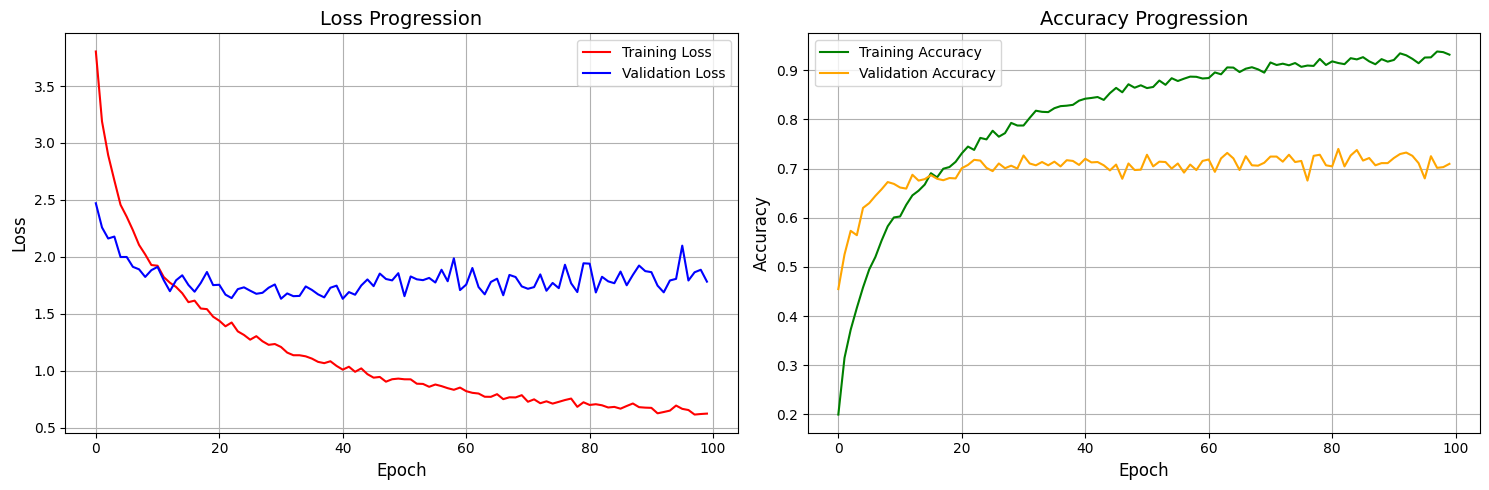

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9984 - loss: 0.4079
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7127 - loss: 1.7657
Validation classification Report 

              precision    recall  f1-score   support

           0       0.73      0.70      0.71       114
           1       0.62      0.38      0.47       141
           2       0.76      0.80      0.78       271
           3       0.93      1.00      0.96        90
           4       0.56      0.50      0.53        18
           5       0.43      0.20      0.27        15
           6       0.25      0.48      0.33        23
           7       1.00      0.98      0.99        44
           8       0.49      0.66      0.56        50
           9       0.79      0.92      0.85        49
          10       0.76      0.67      0.71        48
          11       0.66      0.46      0.54        46
          12       0.78      0.74 

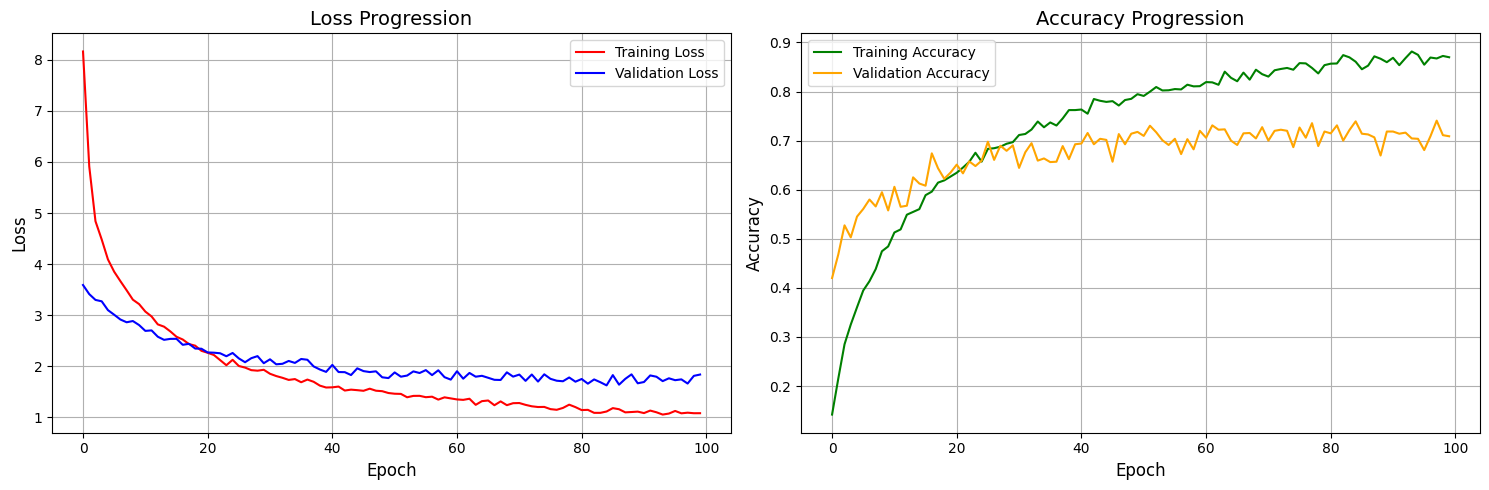

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9616 - loss: 0.7963
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7093 - loss: 1.8617
Validation classification Report 

              precision    recall  f1-score   support

           0       0.78      0.54      0.64       114
           1       0.61      0.46      0.52       141
           2       0.75      0.84      0.79       271
           3       0.94      0.99      0.96        90
           4       0.89      0.44      0.59        18
           5       0.40      0.67      0.50        15
           6       0.59      0.43      0.50        23
           7       1.00      0.95      0.98        44
           8       0.73      0.44      0.55        50
           9       0.83      0.92      0.87        49
          10       0.91      0.65      0.76        48
          11       0.63      0.59      0.61        46
          12       0.70      0.74 

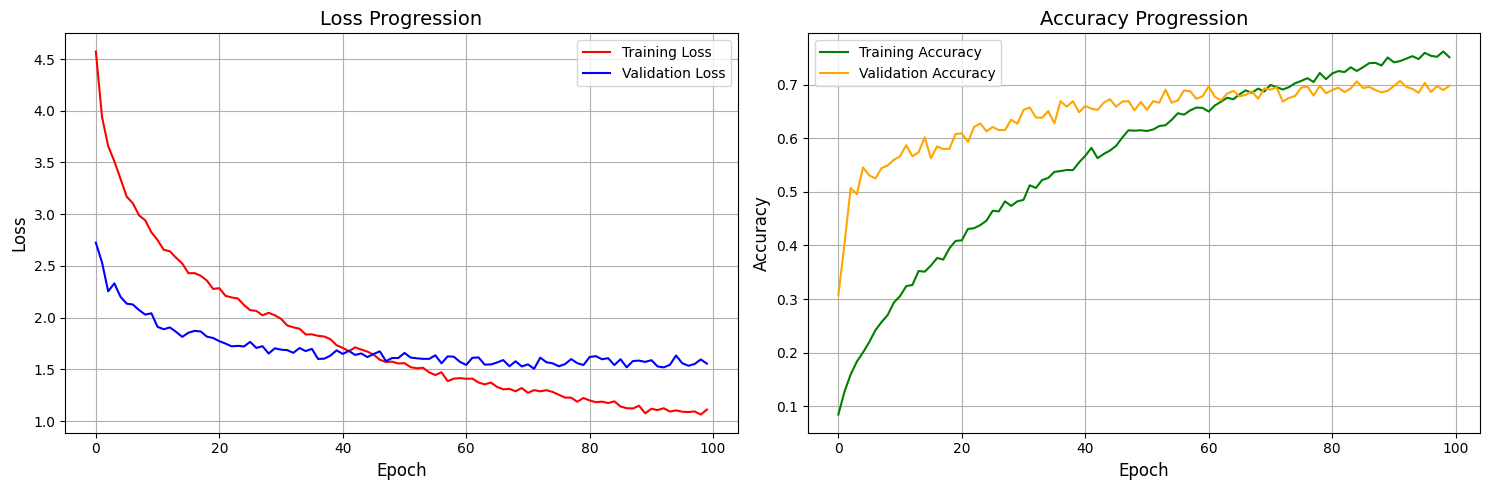

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9383 - loss: 0.5562
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7122 - loss: 1.5515
Validation classification Report 

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       114
           1       0.67      0.50      0.57       141
           2       0.76      0.86      0.81       271
           3       0.87      1.00      0.93        90
           4       0.00      0.00      0.00        18
           5       0.69      0.60      0.64        15
           6       0.38      0.65      0.48        23
           7       0.98      1.00      0.99        44
           8       0.33      0.42      0.37        50
           9       0.90      0.94      0.92        49
          10       0.92      0.69      0.79        48
          11       0.17      0.02      0.04        46
          12       0.74      0.74 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.1757 - loss: 5.5157 - val_accuracy: 0.4348 - val_loss: 2.4720
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3093 - loss: 3.4078 - val_accuracy: 0.5274 - val_loss: 2.1468
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3696 - loss: 2.9735 - val_accuracy: 0.5370 - val_loss: 2.0239
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4442 - loss: 2.5234 - val_accuracy: 0.5452 - val_loss: 1.9270
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4744 - loss: 2.3482 - val_accuracy: 0.5941 - val_loss: 1.8250
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5274 - loss: 2.1771 - val_accuracy: 0.5785 - val_loss: 1.8355
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5766 - loss: 2.0113 - val_accuracy: 0.6422 - val_loss: 1.7359
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5925 - loss: 1.9137 - val_acc

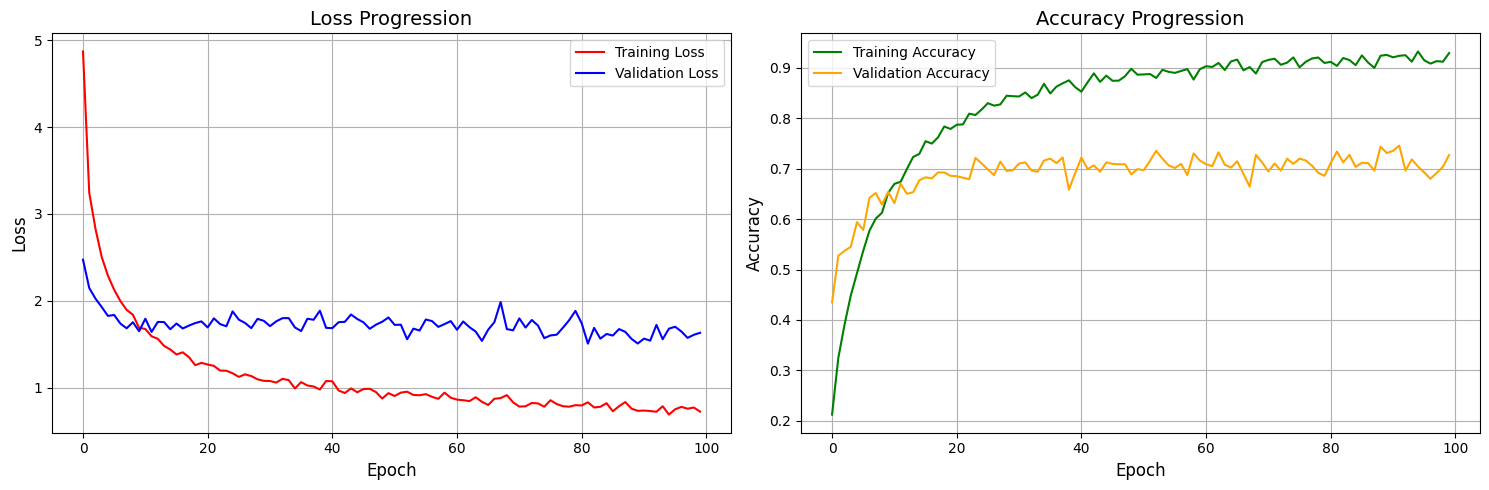

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9916 - loss: 0.4992
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 1.6481
Validation classification Report 

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       114
           1       0.65      0.48      0.55       141
           2       0.80      0.79      0.79       271
           3       0.90      0.99      0.94        90
           4       1.00      0.39      0.56        18
           5       0.71      0.67      0.69        15
           6       0.25      0.57      0.35        23
           7       1.00      0.95      0.98        44
           8       0.55      0.72      0.63        50
           9       0.81      0.94      0.87        49
          10       0.94      0.35      0.52        48
          11       0.71      0.54      0.62        46
          12       0.79      0.70 

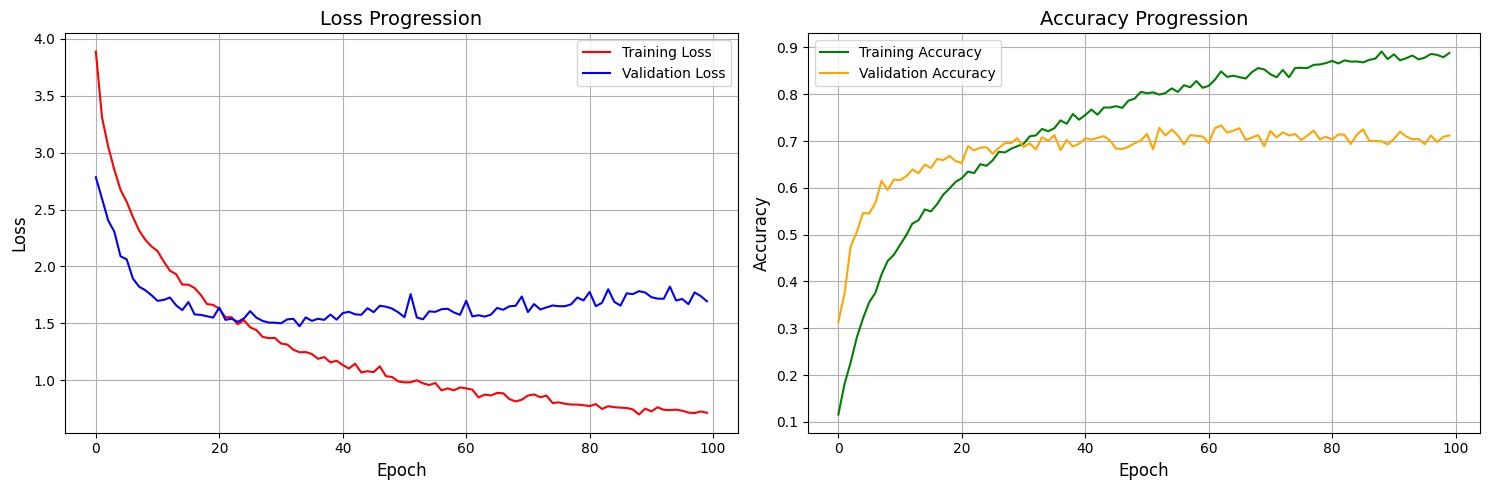

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9937 - loss: 0.3720
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7223 - loss: 1.6702
Validation classification Report 

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       114
           1       0.63      0.63      0.63       141
           2       0.80      0.78      0.79       271
           3       0.87      0.98      0.92        90
           4       0.60      0.17      0.26        18
           5       0.64      0.47      0.54        15
           6       0.35      0.35      0.35        23
           7       0.94      1.00      0.97        44
           8       0.73      0.44      0.55        50
           9       0.78      0.92      0.84        49
          10       0.90      0.58      0.71        48
          11       0.68      0.57      0.62        46
          12       0.67      0.78 

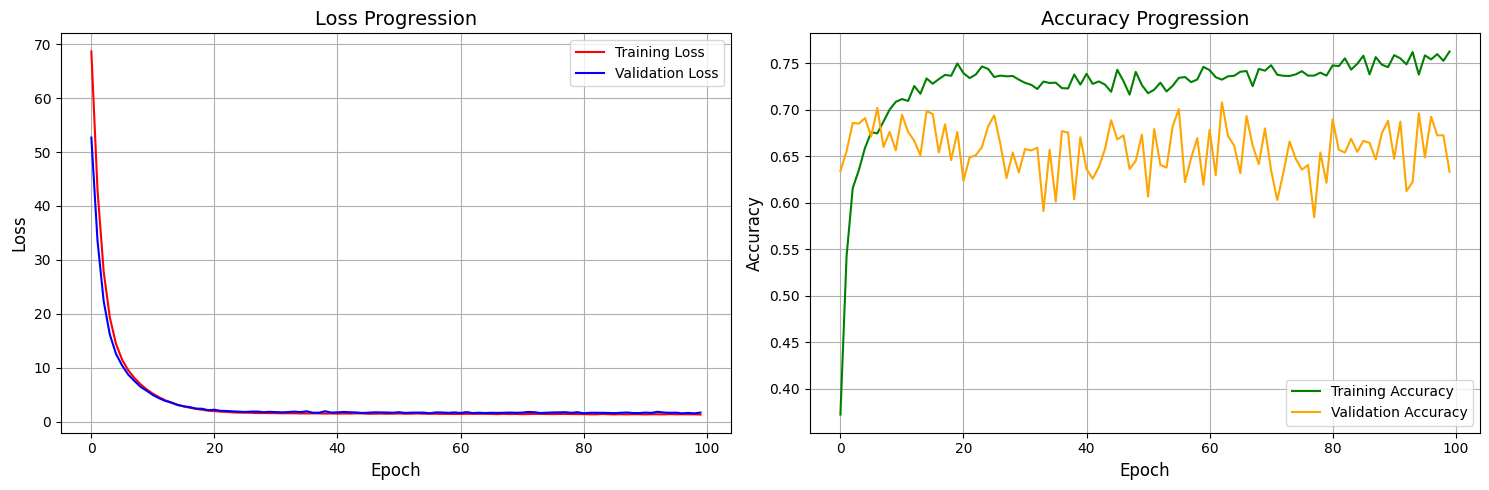

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8694 - loss: 1.1020
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6374 - loss: 1.7283
Validation classification Report 

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       114
           1       0.36      0.45      0.40       141
           2       0.72      0.62      0.67       271
           3       0.82      0.99      0.90        90
           4       0.80      0.22      0.35        18
           5       0.67      0.27      0.38        15
           6       0.34      0.43      0.38        23
           7       1.00      0.86      0.93        44
           8       0.81      0.34      0.48        50
           9       1.00      0.84      0.91        49
          10       0.93      0.52      0.67        48
          11       0.64      0.20      0.30        46
          12       0.70      0.89 

In [23]:
# Build, train, and evaluate models
scaler = StandardScaler()
training_features = scaler.fit_transform(training_features)
validation_features = scaler.transform(validation_features)

build_and_train_models(
    model_configs=model_configs,
    train_features=training_features,
    train_y=train_y,
    val_features=validation_features,
    val_y=val_y,
    train_results=train_results,
    val_results=val_results,
    val_scores=val_scores,
    epochs=100,
    batch_size=32
)

Checking the class weights impact on the best model

In [25]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_y),
                                                  y=train_y)
class_weight_dict = dict(enumerate(class_weights))

config = model_configs['model_4']

# Build model
model = build_model(audio_features=training_features,
                    hidden_layers=config['hidden_layers'],
                    learning_rate=config['learning_rate'],
                    dropout_rate=config['dropout_rate'],
                    regularizer_val=config['regularizer_val'])

In [26]:
history = model.fit(training_features, train_y,
                    validation_data=(validation_features, val_y),
                    epochs=100,
                    batch_size=32,
                    class_weight=class_weight_dict,
                    verbose=1)

Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.1258 - loss: 6.7555 - val_accuracy: 0.4133 - val_loss: 2.5933
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2421 - loss: 4.3383 - val_accuracy: 0.4467 - val_loss: 2.4109
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3093 - loss: 3.4859 - val_accuracy: 0.4607 - val_loss: 2.4628
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3493 - loss: 3.0964 - val_accuracy: 0.4385 - val_loss: 2.3351
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3888 - loss: 2.7147 - val_accuracy: 0.4948 - val_loss: 2.1552
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4545 - loss: 2.5290 - val_accuracy: 0.4689 - val_loss: 2.0432
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4668 - loss: 2.4619 - val_accuracy: 0.5348 - val_loss: 1.9142
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5060 - loss: 2.2637 - val_acc

In [28]:
# Evaluate model on training data
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['model_4_balance'] = model.evaluate(training_features, train_y)[-1]

# Evaluate model on validation data
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['model_4_balance'] = model.evaluate(validation_features, val_y)[-1]

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9290 - loss: 0.7269
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6855 - loss: 1.5558


## Review all the results

In [24]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(3)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(3)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Features')
result_df

,Features,Train_Accuracy,Val_Accuracy
0,model_1,0.998,0.710
1,model_2,0.959,0.709
2,model_3,0.941,0.699
3,model_4,0.992,0.727
4,model_5,0.994,0.712
5,model_6,0.864,0.633


In [ ]:
val_scores_df = pd.DataFrame([(key, value['f1'], value['auc']) for key, value in val_scores.items()],
                             columns=['Features', 'F1_Score', 'AUC_Score']).round(3)

val_scores_df = val_scores_df.sort_values('Features')
print(val_scores_df)